# Convolutional Neural Networks

## Project: Write an Algorithm for a Dog Identification App 

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section, and the specifics of the implementation are marked in the code block with a 'TODO' statement. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to **File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.



---
### Why We're Here 

In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, your code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling.  The image below displays potential sample output of your finished project (... but we expect that each student's algorithm will behave differently!). 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, you will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Your imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Write your Algorithm
* [Step 6](#step6): Test Your Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

Make sure that you've downloaded the required human and dog datasets:
* Download the [dog dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip).  Unzip the folder and place it in this project's home directory, at the location `/dogImages`. 

* Download the [human dataset](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/lfw.zip).  Unzip the folder and place it in the home directory, at location `/lfw`.  

*Note: If you are using a Windows machine, you are encouraged to use [7zip](http://www.7-zip.org/) to extract the folder.*

In the code cell below, we save the file paths for both the human (LFW) dataset and dog dataset in the numpy arrays `human_files` and `dog_files`.

In [128]:
# IMPORTS
import numpy as np
from glob import glob
import cv2                
import matplotlib.pyplot as plt  
from tqdm import tqdm, tqdm_notebook
import torch
import torchvision.models as models
from PIL import Image
import torchvision.transforms as transforms
import os
from torchvision import datasets
import torch.optim as optim


from PIL import ImageFile
%matplotlib inline                               

In [88]:
# load filenames for human and dog images
human_files = np.array(glob("lfw/*/*"))
dog_files = np.array(glob("dogImages/*/*/*"))

# print number of images in each dataset
print('There are %d total human images.' % len(human_files))
print('There are %d total dog images.' % len(dog_files))

There are 13233 total human images.
There are 8351 total dog images.


<a id='step1'></a>
## Step 1: Detect Humans

In this section, we use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  

OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.  In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


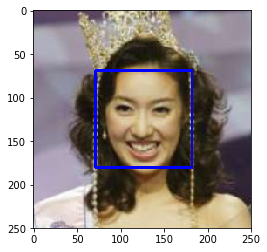

In [89]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[100])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [90]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 
(You can print out your results and/or write your percentages in this cell)

In [92]:
human_files_short = human_files[:100]
dog_files_short = dog_files[:100]

#-#-# Do NOT modify the code above this line. #-#-#
def faces_ratio(image_list):
    count = 0;
    for img in tqdm_notebook(image_list):
        if face_detector(img): count += 1
        
    ratio =  count / len(image_list);
    
    print("Face Detected: {}, Number Images: {}, Ratio: {}".format(count, len(image_list), ratio))    


In [93]:
#RESULTS
print('Human images:')
faces_ratio(human_files_short)

print("---")
print('Dog images:')
faces_ratio(dog_files_short)

Human images:



Face Detected: 100, Number Images: 100, Ratio: 1.0
---
Dog images:



Face Detected: 9, Number Images: 100, Ratio: 0.09


We suggest the face detector from OpenCV as a potential way to detect human images in your algorithm, but you are free to explore other approaches, especially approaches that make use of deep learning :).  Please use the code cell below to design and test your own face detection algorithm.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [ ]:
### (Optional) 
### TODO: Test performance of another face detection algorithm.
### Feel free to use as many code cells as needed.

---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a [pre-trained model](http://pytorch.org/docs/master/torchvision/models.html) to detect dogs in images.  

### Obtain Pre-trained VGG-16 Model

The code cell below downloads the VGG-16 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  

In [97]:
# define VGG16 model
VGG16 = models.vgg16(pretrained=True)

# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA is available
if use_cuda:
    VGG16 = VGG16.cuda()

Given an image, this pre-trained VGG-16 model returns a prediction (derived from the 1000 possible categories in ImageNet) for the object that is contained in the image.

### (IMPLEMENTATION) Making Predictions with a Pre-trained Model

In the next code cell, you will write a function that accepts a path to an image (such as `'dogImages/train/001.Affenpinscher/Affenpinscher_00001.jpg'`) as input and returns the index corresponding to the ImageNet class that is predicted by the pre-trained VGG-16 model.  The output should always be an integer between 0 and 999, inclusive.

Before writing the function, make sure that you take the time to learn  how to appropriately pre-process tensors for pre-trained models in the [PyTorch documentation](http://pytorch.org/docs/stable/torchvision/models.html).

In [98]:

ImageFile.LOAD_TRUNCATED_IMAGES = True

def predict(model, img_path):
    '''
    Use pre-trained VGG-16 model to obtain index corresponding to 
    predicted ImageNet class for image at specified path
    
    Args:
        img_path: path to an image
        
    Returns:
        Index corresponding to VGG-16 model's prediction
    '''
    

    ## Load and pre-process an image from the given img_path
    transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
    ])
    image = transform(Image.open(img_path))
    
    image = image.view(1,3,224,224)
    if use_cuda:
        image = image.cuda()
        
    # Get probabilities for given image
    probabilities = model(image)
    

    # Return index
    _, index = torch.max(probabilities, 1)
    
    return index.item()# predicted class index


### (IMPLEMENTATION) Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), you will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained VGG-16 model, we need only check if the pre-trained model predicts an index between 151 and 268 (inclusive).

Use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [99]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(model, img_path):
    ## TODO: Complete the function.
    image_net_index = predict(model, img_path)
    
    return image_net_index >= 151 and image_net_index <= 268

### (IMPLEMENTATION) Assess the Dog Detector

__Question 2:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 


In [100]:
### TODO: Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
def dog_ratio(model, image_list):
    count = 0;
    for img in tqdm_notebook(image_list):
        if dog_detector(model, img): count += 1
        
    ratio =  count / len(image_list);
    
    print("Dog Detected: {}, Number Images: {}, Ratio: {}".format(count, len(image_list), ratio))    


In [101]:
#RESULTS FOR VGG16
print('Human images:')
dog_ratio(VGG16, human_files_short)

print("---")
print('Dog images:')
dog_ratio(VGG16, dog_files_short)

Human images:



Dog Detected: 0, Number Images: 100, Ratio: 0.0
---
Dog images:



Dog Detected: 100, Number Images: 100, Ratio: 1.0


We suggest VGG-16 as a potential network to detect dog images in your algorithm, but you are free to explore other pre-trained networks (such as [Inception-v3](http://pytorch.org/docs/master/torchvision/models.html#inception-v3), [ResNet-50](http://pytorch.org/docs/master/torchvision/models.html#id3), etc).  Please use the code cell below to test other pre-trained PyTorch models.  If you decide to pursue this _optional_ task, report performance on `human_files_short` and `dog_files_short`.

In [102]:
### (Optional) 
### Experiment with ResNet50

RESNET = models.resnet50(pretrained=True);
# check if CUDA is available
use_cuda = torch.cuda.is_available()

# move model to GPU if CUDA ibs available
if use_cuda:
    RESNET = RESNET.cuda()

In [104]:
#RESULTS FOR ResNet50
print('Human images:')
dog_ratio(RESNET, human_files_short)

print("---")
print('Dog images:')
dog_ratio(RESNET, dog_files_short)

Human images:


Dog Detected: 0, Number Images: 100, Ratio: 0.0
---
Dog images:


Dog Detected: 0, Number Images: 100, Ratio: 0.0


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 10%.  In Step 4 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have trouble distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun!

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively).  You may find [this documentation on custom datasets](http://pytorch.org/docs/stable/torchvision/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](http://pytorch.org/docs/stable/torchvision/transforms.html?highlight=transform)!

In [129]:
normalization = {
    'mean':(0.485, 0.456, 0.406),
    'std':(0.229, 0.224, 0.225)
}


train_transform = transforms.Compose([
    transforms.Resize(250),
    transforms.RandomRotation(15),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(0.2),
    transforms.ToTensor(),
    transforms.Normalize(normalization['mean'],normalization['std']),
])

test_transform = transforms.Compose([
    transforms.Resize(250),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(normalization['mean'],normalization['std']),
])

valid_transform = test_transform

directory = './dogImages/'

train_dataset = datasets.ImageFolder(directory + 'train', transform=train_transform)
test_dataset = datasets.ImageFolder(directory + 'test', transform=test_transform)
valid_dataset = datasets.ImageFolder(directory + 'valid', transform=valid_transform)


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=32, shuffle=True)


classes = train_dataset.classes

**Question 3:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?


Nb train images 6680
Nb Test images 836
Nb Classes 133


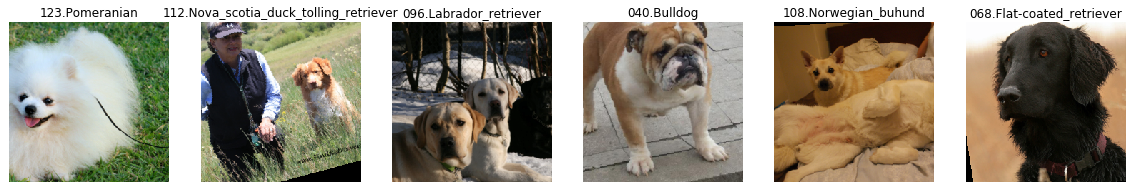

In [130]:
import matplotlib.pyplot as plt                        
%matplotlib inline          

generator = iter(train_loader)

images, labels = next(generator)

def im_convert(tensor):
    """ Display a tensor as an image. """
    
    image = tensor.to("cpu").clone().detach()
    image = image.numpy().squeeze()
    image = image.transpose(1,2,0)
    image = image * np.array(normalization['std']) + np.array(normalization['mean'])
    image = image.clip(0, 1)

    return image

    
    
def display_images(images, labels):
    fig, axes = plt.subplots(figsize=(20,4), ncols=6)
    for i in range(len(images)):
        ax = axes[i]
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.tick_params(axis='both', length=0)
        ax.set_xticklabels('')
        ax.set_yticklabels('')
        ax.set_title(classes[labels[i].item()])
        ax.imshow(im_convert(images[i]))


display_images(images[:6], labels[:6])
    
print("Nb train images {}".format(len(train_dataset)))
print("Nb Test images {}".format(len(test_dataset)))
print("Nb Classes {}".format(len(classes)))

**Answer**:
Transformations: 
- RandomCrop: Randomize the crop to remove position dependency in the learning
- HorizontalFlip: To artifically augment the subset (althouth this might not be necessary since the detected object are kind off symetric)
- RandomRotation: Apply random rotation to increase detection robustness



### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  Use the template in the code cell below.

In [131]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layer (sees 3x224x224x3 image tensor)
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        # convolutional layer (sees 16x112x112 tensor)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # convolutional layer (sees 32x56x56 tensor)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # convolutional layer (sees 64x28x28 tensor)
        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
        # convolutional layer (sees 128x14x14 tensor)
        self.conv5 = nn.Conv2d(128, 256, 3, padding=1) 
        # 512 add conv layer 
        self.conv6 = nn.Conv2d(256, 512, 3, padding=1) 
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # linear layer (256x7x7 -> 5000)
        self.fc1 = nn.Linear(512 * 3 * 3, 2000)
        # linear layer (1000 -> 500)
        self.fc2 = nn.Linear(2000, 1000)
        # linear layer (500)
        self.fc3 = nn.Linear(1000, 133)
        
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.25) # => try up to .5
        ## Define layers of a CNN
    
    def forward(self, x):
        ## Convolution and pooling layers
        
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))
        x = self.pool(F.relu(self.conv6(x)))
        
        # Fully connected layers + dropout
        x = x.view(-1, 512 * 3 * 3)

        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        
        x = self.dropout(x)
        #x = F.sigmoid(self.fc3(x))
        x = self.fc3(x)
        
        return x

#-#-# You do NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model_scratch = Net()
print(model_scratch)

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4608, out_features=2000, bias=True)
  (fc2): Linear(in_features=2000, out_features=1000, bias=True)
  (fc3): Linear(in_features=1000, out_features=133, bias=True)
  (dropout): Dropout(p=0.25)
)


__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

__Answer:__ 


The choice journey to find the final CNN architecture: 
### Trial 1: Shallow network with SDG and Adam
3 conv / pooling layers with SDG optimizer. 
With this architecture I have not been able to raiset the Accuracy above 6%. After 25 epoch the valid and train losses started to diverge showing signs of overfitting. 

I the tried to change the optimizer to Adam to see if this would work better. This attempt was actually worse.  The model making no progress at all (I shut down the training after 10 epochs or so)

Every architecture was tested with a variety of learning rate from 0.1 down to 0.0001 making very little difference in the convergence speed as well as on the accuracy. 

At this point I was not sure why the adam optimizer was performing worse but I assumed that the relatively poor preformances was due the the shallowness of the network failing to embrasse the subtlety of dog breed difference.

### Trial 2: A little deeper
I the tried a 5 conv / pooling layer with Adam optimizer with no more progress the the first time. I shut is down after 10 epochs
Changing the optimizer with SGD with a learning rate at 0.001 I saw an slight increase on the training losses and decided to train it for 90 epochs. I have only been able to reach 8% accuracy. 

At this point I was failing to find a solution. None of the parameters I chose seems to have a decisive impact on the convergence rate nor the accuracy.  I started to wonder if something was wrong in my implementation of the training function or the way I was loading data. 

I then settle a call with my mentor who gave me precious advices, reasuring me in the first place on my implementation. 
He suggested me to add a 6th convolutional layer.  And check more various optimizer.

### Trial 3: Go Deeper and find the way

I added a 6th layer on my network the last layer shape would be (512, 3, 3). 
I tried multiple optimizers:
First Adam showing no progress at all.
Then Rmsprop
This time something happend!
After 40 epochs **I have been able to reach 34% accuracy.** Which is not perfect but above the requirement. 

Plotting the train_loss and valid loss along side. I have been able to see that the model was starting to overfit after the 35th epoch. 


This process has been very interesting for me because I learned the key to success when training a model and searching for the right configuration: endurance.  

This said I still do not fully understand why the Adam optmizer seem to preform this poorly.
This gave motivation to understand in more detail how the various optimizers works and in what configuration they perform best. 


### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  Save the chosen loss function as `criterion_scratch`, and the optimizer as `optimizer_scratch` below.

In [132]:
### Select loss function
criterion_scratch = torch.nn.CrossEntropyLoss()  #  MSE => cross  entropy => categorical Cross entropy loss

### Select optimizer
optimizer_scratch = optim.RMSprop(model_scratch.parameters(), lr=0.001) # Rmsprop => SGD => Adam

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_scratch.pt'`.

In [133]:
# the following import is required for training to be robust to truncated images
ImageFile.LOAD_TRUNCATED_IMAGES = True


def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    train_losses = []
    valid_losses = []

    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in tqdm_notebook(enumerate(loaders['train']),total=len(loaders['train'])):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            
            # Reset gradient
            optimizer.zero_grad()
            # forward pass
            output = model(data)
            # calculate loss
            loss = criterion(output, target)
            # Run backpropagation
            loss.backward()
            # adjust weights
            optimizer.step()
            
            
            train_loss += (1 / (batch_idx + 1)) * (loss.item() - train_loss)
 
            
            
            ## record the average training loss, using something like
            ## train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss)) ??? why is batch_idx involved???
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            # forward pass
            output = model(data)
            # calculate loss
            loss = criterion(output, target)
            
            valid_loss += (1 / (batch_idx + 1)) * (loss.item() - valid_loss)

            

            
        # print training/validation statistics 
        should_save = valid_loss < valid_loss_min
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}, Model Saved {}'.format(
            epoch, 
            train_loss,
            valid_loss,
            should_save
            ))
        
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        
        ## TODO: save the model if validation loss has decreased
        if should_save:
            valid_loss_min = valid_loss
            torch.save(model.state_dict(), save_path)
            
    # return trained model
    return (model, train_losses, valid_losses)



In [135]:
loaders_scratch = {
    'valid': valid_loader,
    'train': train_loader,
    'test': test_loader,
}

#model_scratch.load_state_dict(torch.load('model_scratch.pt'))
# train the model
(model_scratch, train_losses, valid_losses) = train(50, loaders_scratch, model_scratch, optimizer_scratch, 
                      criterion_scratch, use_cuda, 'model_scratch.pt')

# load the model that got the best validation accuracyb
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

Epoch: 1 	Training Loss: 16.288840 	Validation Loss: 4.719178, Model Saved True


Epoch: 2 	Training Loss: 4.697318 	Validation Loss: 4.627544, Model Saved True


Epoch: 3 	Training Loss: 4.581325 	Validation Loss: 4.504111, Model Saved True


Epoch: 4 	Training Loss: 4.479046 	Validation Loss: 4.428484, Model Saved True


Epoch: 5 	Training Loss: 4.369046 	Validation Loss: 4.404968, Model Saved True


Epoch: 6 	Training Loss: 4.285376 	Validation Loss: 4.146780, Model Saved True


Epoch: 7 	Training Loss: 4.168143 	Validation Loss: 4.050421, Model Saved True


Epoch: 8 	Training Loss: 4.063987 	Validation Loss: 4.040350, Model Saved True


Epoch: 9 	Training Loss: 3.973164 	Validation Loss: 3.927551, Model Saved True


Epoch: 10 	Training Loss: 3.874871 	Validation Loss: 3.918047, Model Saved True


Epoch: 11 	Training Loss: 3.775005 	Validation Loss: 3.835525, Model Saved True


Epoch: 12 	Training Loss: 3.696995 	Validation Loss: 3.801084, Model Saved True


Epoch: 13 	Training Loss: 3.588507 	Validation Loss: 3.597790, Model Saved True


Epoch: 14 	Training Loss: 3.530121 	Validation Loss: 3.776425, Model Saved False


Epoch: 15 	Training Loss: 3.433249 	Validation Loss: 3.643247, Model Saved False


Epoch: 16 	Training Loss: 3.330952 	Validation Loss: 3.673308, Model Saved False


Epoch: 17 	Training Loss: 3.268917 	Validation Loss: 3.401168, Model Saved True


Epoch: 18 	Training Loss: 3.163000 	Validation Loss: 3.353655, Model Saved True


Epoch: 19 	Training Loss: 3.076036 	Validation Loss: 3.316528, Model Saved True


Epoch: 20 	Training Loss: 3.007365 	Validation Loss: 3.300736, Model Saved True


Epoch: 21 	Training Loss: 2.921360 	Validation Loss: 3.167617, Model Saved True


Epoch: 22 	Training Loss: 2.826238 	Validation Loss: 3.375587, Model Saved False


Epoch: 23 	Training Loss: 2.774151 	Validation Loss: 3.162283, Model Saved True


Epoch: 24 	Training Loss: 2.666057 	Validation Loss: 3.186982, Model Saved False


Epoch: 25 	Training Loss: 2.645502 	Validation Loss: 3.154696, Model Saved True


Epoch: 26 	Training Loss: 2.547131 	Validation Loss: 3.340168, Model Saved False


Epoch: 27 	Training Loss: 2.463563 	Validation Loss: 3.085418, Model Saved True


Epoch: 28 	Training Loss: 2.419840 	Validation Loss: 3.147351, Model Saved False


Epoch: 29 	Training Loss: 2.339700 	Validation Loss: 3.149481, Model Saved False


Epoch: 30 	Training Loss: 2.293218 	Validation Loss: 2.985265, Model Saved True


Epoch: 31 	Training Loss: 2.255832 	Validation Loss: 2.859817, Model Saved True


Epoch: 32 	Training Loss: 2.191576 	Validation Loss: 2.909329, Model Saved False


Epoch: 33 	Training Loss: 2.137564 	Validation Loss: 2.869129, Model Saved False


Epoch: 34 	Training Loss: 2.107418 	Validation Loss: 3.083322, Model Saved False


Epoch: 35 	Training Loss: 2.026721 	Validation Loss: 3.049420, Model Saved False


Epoch: 36 	Training Loss: 2.008532 	Validation Loss: 2.923893, Model Saved False


Epoch: 37 	Training Loss: 1.993515 	Validation Loss: 3.026759, Model Saved False


Epoch: 38 	Training Loss: 1.939207 	Validation Loss: 2.998768, Model Saved False


Epoch: 39 	Training Loss: 1.902464 	Validation Loss: 2.887408, Model Saved False


Epoch: 40 	Training Loss: 1.859992 	Validation Loss: 2.917003, Model Saved False


Epoch: 41 	Training Loss: 1.806848 	Validation Loss: 2.957533, Model Saved False


Epoch: 42 	Training Loss: 1.776176 	Validation Loss: 3.228798, Model Saved False


Epoch: 43 	Training Loss: 1.783115 	Validation Loss: 2.910222, Model Saved False


Epoch: 44 	Training Loss: 1.745100 	Validation Loss: 2.862924, Model Saved False


Epoch: 45 	Training Loss: 1.684824 	Validation Loss: 3.025345, Model Saved False


Epoch: 46 	Training Loss: 1.667085 	Validation Loss: 3.063207, Model Saved False


Epoch: 47 	Training Loss: 1.638127 	Validation Loss: 3.072041, Model Saved False


Epoch: 48 	Training Loss: 1.636804 	Validation Loss: 2.761074, Model Saved True


Epoch: 49 	Training Loss: 1.572343 	Validation Loss: 2.850800, Model Saved False


Epoch: 50 	Training Loss: 1.578624 	Validation Loss: 3.118257, Model Saved False


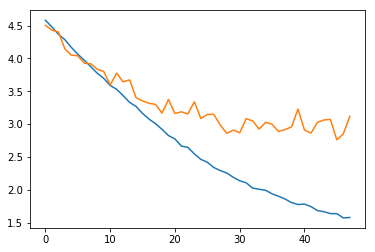

In [137]:
plt.plot(train_losses[2:])
plt.plot(valid_losses[2:])
plt.show()


model_scratch.load_state_dict(torch.load('model_scratch.pt'))



### Best model: 
- optimizer: Rmsprom
- loss: cross entropyloss
- learning rate: 0.001
- model:
```
Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4608, out_features=2000, bias=True)
  (fc2): Linear(in_features=2000, out_features=1000, bias=True)
  (fc3): Linear(in_features=1000, out_features=133, bias=True)
  (dropout): Dropout(p=0.25)
)
```
#### Results
40 epochs => 34%

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images.  Use the code cell below to calculate and print the test loss and accuracy.  Ensure that your test accuracy is greater than 10%.

In [138]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

In [139]:
# call test function    
test(loaders_scratch, model_scratch, criterion_scratch, use_cuda)

Test Loss: 2.836208


Test Accuracy: 32% (271/836)


---
<a id='step4'></a>
## Step 4: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

### (IMPLEMENTATION) Specify Data Loaders for the Dog Dataset

Use the code cell below to write three separate [data loaders](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dogImages/train`, `dogImages/valid`, and `dogImages/test`, respectively). 

If you like, **you are welcome to use the same data loaders from the previous step**, when you created a CNN from scratch.

In [4]:

normalization = {
    'mean':(0.485, 0.456, 0.406),
    'std':(0.229, 0.224, 0.225)
}


train_transform = transforms.Compose([
    transforms.Resize(250),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(0.2),
    transforms.ToTensor(),
    transforms.Normalize(normalization['mean'],normalization['std']),
])

test_transform = transforms.Compose([
    transforms.Resize(250),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(normalization['mean'],normalization['std']),
])

valid_transform = test_transform

directory = './dogImages/'

train_dataset = datasets.ImageFolder(directory + 'train', transform=train_transform)
test_dataset = datasets.ImageFolder(directory + 'test', transform=test_transform)
valid_dataset = datasets.ImageFolder(directory + 'valid', transform=valid_transform)


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=32, shuffle=True)


classes = train_dataset.classes

#ResNet50
#VGG16
#VGG19




### (IMPLEMENTATION) Model Architecture

Use transfer learning to create a CNN to classify dog breed.  Use the code cell below, and save your initialized model as the variable `model_transfer`.

In [6]:
import torchvision.models as models
import torch.nn as nn

## TODO: Specify model architecture 
model_transfer = models.resnet50(pretrained=True);



for parameter in model_transfer.parameters():
    parameter.require_grad = False

fc = nn.Linear(2048, len(classes))
model_transfer.fc = fc


print(model_transfer)

use_cuda = torch.cuda.is_available()

if use_cuda:
    model_transfer = model_transfer.cuda()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__

First ResNet50

### (IMPLEMENTATION) Specify Loss Function and Optimizer

Use the next code cell to specify a [loss function](http://pytorch.org/docs/master/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/master/optim.html).  Save the chosen loss function as `criterion_transfer`, and the optimizer as `optimizer_transfer` below.

In [8]:
import torch.optim as optim
criterion_transfer = nn.CrossEntropyLoss()

optimizer_transfer = optim.SGD(model_transfer.fc.parameters(), lr=0.001)

### (IMPLEMENTATION) Train and Validate the Model

Train and validate your model in the code cell below.  [Save the final model parameters](http://pytorch.org/docs/master/notes/serialization.html) at filepath `'model_transfer.pt'`.

In [21]:
# train the model
loaders_transfer = {
    'valid': valid_loader,
    'train': train_loader,
    'test': test_loader,
}

n_epochs = 20
(model_transfer, train_losses, valid_losses) = train(n_epochs, loaders_transfer, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

# load the model that got the best validation accuracy (uncomment the line below)
#model_transfer.load_state_dict(torch.load('model_transfer.pt'))


Epoch: 1 	Training Loss: 3.240303 	Validation Loss: 3.077316, Model Saved True



Epoch: 2 	Training Loss: 3.116500 	Validation Loss: 2.910379, Model Saved True



Epoch: 3 	Training Loss: 3.006456 	Validation Loss: 2.810108, Model Saved True



Epoch: 4 	Training Loss: 2.890447 	Validation Loss: 2.725980, Model Saved True



Epoch: 5 	Training Loss: 2.785040 	Validation Loss: 2.591675, Model Saved True



Epoch: 6 	Training Loss: 2.691388 	Validation Loss: 2.482506, Model Saved True



Epoch: 7 	Training Loss: 2.599002 	Validation Loss: 2.412714, Model Saved True



Epoch: 8 	Training Loss: 2.508520 	Validation Loss: 2.295459, Model Saved True



Epoch: 9 	Training Loss: 2.424808 	Validation Loss: 2.243449, Model Saved True



Epoch: 10 	Training Loss: 2.339353 	Validation Loss: 2.152955, Model Saved True



Epoch: 11 	Training Loss: 2.271913 	Validation Loss: 2.072619, Model Saved True



Epoch: 12 	Training Loss: 2.198592 	Validation Loss: 2.004857, Model Saved True



Epoch: 13 	Training Loss: 2.131494 	Validation Loss: 1.965400, Model Saved True



Epoch: 14 	Training Loss: 2.066579 	Validation Loss: 1.892877, Model Saved True



Epoch: 15 	Training Loss: 2.005942 	Validation Loss: 1.809769, Model Saved True



Epoch: 16 	Training Loss: 1.956634 	Validation Loss: 1.777224, Model Saved True



Epoch: 17 	Training Loss: 1.899348 	Validation Loss: 1.705912, Model Saved True



Epoch: 18 	Training Loss: 1.841957 	Validation Loss: 1.666706, Model Saved True



Epoch: 19 	Training Loss: 1.801451 	Validation Loss: 1.654907, Model Saved True



Epoch: 20 	Training Loss: 1.750161 	Validation Loss: 1.579551, Model Saved True


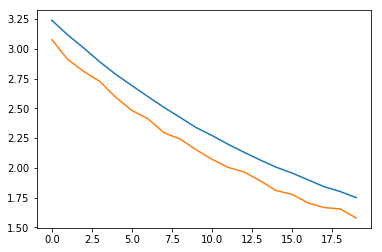

In [25]:
import matplotlib.pyplot as plt                        


plt.plot(train_losses)
plt.plot(valid_losses)
plt.show()


### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Use the code cell below to calculate and print the test loss and 
accuracy.  Ensure that your test accuracy is greater than 60%.

In [32]:
model_transfer.load_state_dict(torch.load('model_transfer.pt'))
test(loaders_transfer, model_transfer, criterion_transfer, use_cuda)

Test Loss: 1.573635


Test Accuracy: 77% (650/836)


### (IMPLEMENTATION) Predict Dog Breed with the Model

Write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan hound`, etc) that is predicted by your model.  

In [113]:
### TODO: Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.
from PIL import Image
import requests
from io import BytesIO

# list of class names by index, i.e. a name can be accessed like class_names[0]
#class_names = [item[4:].replace("_", " ") for item in data_transfer['train'].classes]

def load_image(img_path):
    if "http" in img_path:
        response = requests.get(img_path)
        image = Image.open(BytesIO(response.content)).convert('RGB')
    else:
        image = Image.open(img_path).convert('RGB')
    
    return image
    

def predict_image(img_path, model, classes):
    max_size = 224
    
    # Load image
    image = load_image(img_path)
        
    if max(image.size) > max_size:
        size = max_size
    
    in_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.CenterCrop(max_size),
                        transforms.ToTensor(),
                        transforms.Normalize((0.485, 0.456, 0.406), 
                                             (0.229, 0.224, 0.225))])
    image = in_transform(image)[:3,:,:].unsqueeze(0)
    #print(image.shape)
    model.eval()
    output = model(image.cuda())
    prediction = output.data.max(1, keepdim=True)[1]
    return classes[prediction]
    
def predict_breed_transfer(img_path):
    return predict_image(img_path, model_transfer, classes)

### Test on real image

<img src="https://cdn1.medicalnewstoday.com/content/images/articles/322/322868/golden-retriever-puppy.jpg" width="150">



In [70]:
predict_breed_transfer("https://cdn1.medicalnewstoday.com/content/images/articles/322/322868/golden-retriever-puppy.jpg")

'112.Nova_scotia_duck_tolling_retriever'

---
<a id='step5'></a>
## Step 5: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 4 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

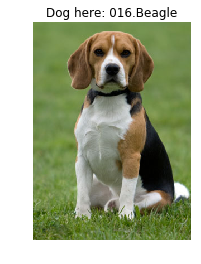

In [125]:
### TODO: Write your algorithm.
### Feel free to use as many code cells as needed.

model_transfer.load_state_dict(torch.load('model_transfer.pt'))
def run_app(img_path):
    error = False
    if dog_detector(VGG16, img_path):
        title = 'Dog here: '
    elif face_detector(img_path):
        title = 'Hello Human: '
    else: 
        error = True
        title = 'Nor dog or human try again'
    
    if not error:
        breed = predict_breed_transfer(img_path)
        title += breed

    
    image = load_image(img_path)
    plt.imshow(image)
    plt.axis('off')    
    plt.title(title)

        
    
#run_app("./dogImages/test/006.American_eskimo_dog/American_eskimo_dog_00452.jpg")
run_app("./dogImages/test/016.Beagle/Beagle_01141.jpg")

---
<a id='step6'></a>
## Step 6: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that _you_ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ (Three possible points for improvement)

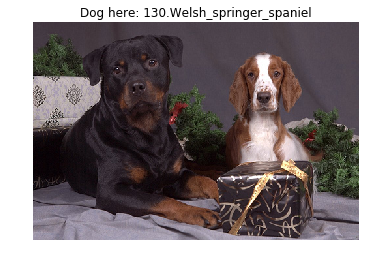

In [127]:
## TODO: Execute your algorithm from Step 6 on
## at least 6 images on your computer.
## Feel free to use as many code cells as needed.

## suggested code, below
for file in np.hstack((human_files[:3], dog_files[:3])):
    run_app(file)